In [43]:
import seaborn as sns

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from joblib import load, dump
import pandas as pd

In [37]:
model_log = load("Objects/Models/model_log.joblib")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
y = torch.load("Objects/Data/labels.pt")
X = torch.load("Objects/Data/padded_glove_embeddings.pt")

In [5]:
class Data(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = X.size(0)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.n_samples
        

In [6]:
data = Data(X, y)

In [7]:
train_data, test_data = random_split(data, [4000, 846])

In [8]:
batch_size=5

In [9]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [14]:
# define model architechture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,1,(1,300), stride=1)
        self.conv2 = nn.Conv2d(1,1,(2,1), stride=1)
        self.conv3 = nn.Conv1d(1,1,(3,300), stride=1)
        self.pool1 = nn.MaxPool2d((4,1))
        self.pool2 = nn.AvgPool2d((4,1))
        
        self.activation = nn.ReLU()
        
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(22, 3)
    def forward(self, x):
        
        output = self.conv1(x)
        output = self.pool2(output)
        # output = self.conv2(output)
        # output = self.pool2(output)
        output = self.flat(output)
        output = self.linear1(output)
        
        return output

In [15]:
model = CNN()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [16]:
# hypereparameters
num_epochs = 10
n_total_steps = len(train_loader)

In [17]:
total_losses = []
total_loss = 0
print_steps = 300
loss_step = 25
for epoch in range(num_epochs):
    for i, (feature, label) in enumerate(train_loader):
        
        feature = feature.to(device)
        label = label.to(device)
        feature = feature.view(batch_size, 1, 88, 300)
        
        #forward pass
        outputs = model(feature.float())
        loss = criterion(outputs, label)
        total_loss += loss
        
        #back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #log
        if (i + 1) % print_steps == 0:
            print(f'Loss: {total_losses[-1]} --- epoch: {epoch+1}, step: {i+1}/{n_total_steps}') 
            print(feature.size())
        if (i + 1) % loss_step == 0:
            avg_loss = total_loss / loss_step
            total_losses.append(avg_loss.item())
            total_loss = 0
               

Loss: 1.052107572555542 --- epoch: 1, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 1.0161477327346802 --- epoch: 1, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 0.963895857334137 --- epoch: 2, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 0.9291488528251648 --- epoch: 2, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 0.9181738495826721 --- epoch: 3, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 0.9433757066726685 --- epoch: 3, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 0.8859096765518188 --- epoch: 4, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 0.882100522518158 --- epoch: 4, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 1.0221188068389893 --- epoch: 5, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 0.9435437917709351 --- epoch: 5, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 0.9676586389541626 --- epoch: 6, step: 300/800
torch.Size([5, 1, 88, 300])
Loss: 0.8709978461265564 --- epoch: 6, step: 600/800
torch.Size([5, 1, 88, 300])
Loss: 0.932421088218689 --- epo

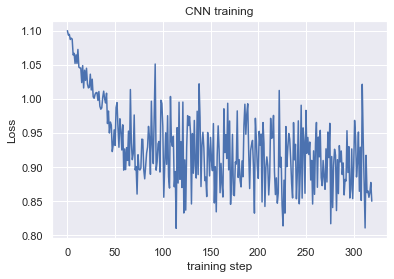

In [51]:
sns.set_theme()
_ = sns.lineplot(x=range(len(total_losses)), y=total_losses)
_ = plt.xlabel("training step")
_ = plt.ylabel("Loss")
_ = plt.title("CNN training")
plt.savefig("CNNTraining.png")

In [28]:
with torch.no_grad():
    predictions = torch.tensor([])
    labels = torch.tensor([])
    for feature, label in test_loader:
        feature = feature.to(device)

        feature = feature.view(feature.size()[0],1,88,300)
        label = label.to(device)
        outputs = model(feature.float())
        _, predicted = torch.max(outputs, 1)
        
        predictions = torch.cat([predictions, predicted])
        labels = torch.cat([label, labels])

In [29]:
accuracy = ((predictions == labels).sum() / 846).item()

In [30]:
predictions

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [31]:
labels

tensor([0., 1., 1., 1., 1., 0., 0., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2., 2.,
        1., 2., 0., 1., 2., 1., 2., 2., 2., 0., 1., 1., 2., 1., 2., 1., 2., 1.,
        1., 1., 2., 1., 2., 1., 1., 0., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1.,
        1., 0., 2., 1., 1., 0., 2., 0., 1., 1., 1., 2., 1., 1., 2., 2., 2., 1.,
        2., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1.,
        0., 2., 1., 1., 1., 1., 1., 0., 1., 2., 2., 1., 1., 0., 2., 0., 1., 1.,
        1., 1., 1., 2., 1., 0., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 2., 1.,
        0., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
        1., 2., 1., 1., 1., 1., 1., 2., 1., 0., 2., 1., 1., 0., 1., 2., 2., 1.,
        1., 1., 2., 1., 0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
        1., 2., 2., 2., 2., 0., 2., 1., 2., 1., 2., 1., 1., 2., 2., 1., 1., 0.,
        1., 1., 2., 2., 1., 2., 2., 1., 2., 1., 1., 2., 1., 2., 0., 2., 2., 0.,
        1., 1., 1., 1., 1., 2., 1., 2., 

In [32]:
def log_model(model, acc, **params):
    log_entry = {
        "model": model,
        "accuracy": acc,
        
    }
    for i in params:
        log_entry[i] = params[i]
    
    model_log.append(log_entry)

In [33]:
model

CNN(
  (conv1): Conv2d(1, 1, kernel_size=(1, 300), stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(2, 1), stride=(1, 1))
  (conv3): Conv1d(1, 1, kernel_size=(3, 300), stride=(1,))
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (pool2): AvgPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0)
  (activation): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=22, out_features=3, bias=True)
)

In [34]:
params = {
    "model_name": "CNN",
    "layers": ["Conv", "MaxPool", "Linear"],
    "hidden_sizes": [None, None, None],
    "activation": [None, None, None],
    "dropout": [None, None, None],
    "notes": "Baseline CNN backpropagated its way into predicting all 1s(neutral)"
}

In [38]:
log_model(model, accuracy, **params)

In [39]:
pd.DataFrame().from_dict(model_log)

,model,accuracy,model_name,penalty,C,solver,layers,hidden_sizes,activation,dropout,notes
0,"(CountVectorizer(), LogisticRegression(C=1, ma...",0.785567,logistic regression,l2,1.00,lbfgs,NaN,NaN,NaN,NaN,NaN
1,"(CountVectorizer(), LogisticRegression(C=0.55,...",0.785567,logistic regression,l2,0.55,sag,NaN,NaN,NaN,NaN,NaN
2,"(CountVectorizer(), XGBClassifier(base_score=0...",0.784536,XGBClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"CNN(\n (conv1): Conv2d(1, 1, kernel_size=(1, ...",0.579196,CNN,NaN,NaN,NaN,"[Conv, MaxPool, Linear]","[None, None, None]","[None, None, None]","[None, None, None]",Baseline CNN backpropagated its way into predi...


In [ ]:
# Save new model log
